Here we futher clean the data and prepare it for Modelling.
- Remove Collinear Features/Features with high mulit-collinearity
- Log Transform target variable
- Label Encode
- Drop unrequired columns
- Any additional cleaning


In [2]:
import numpy as np
from numpy.random import randn
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

In [48]:
df = pd.read_csv('HDB 1719 with Distance Features.csv')
df.head(1)

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,flat,school_dist,num_school_2km,hawker_dist,num_hawker_2km,mrt_dist,num_mrt_2km,supermarket_dist,num_supermarket_2km,dist_central,region,Price_per_SF,real_price
0,QUEENSTOWN,4 ROOM,04 TO 06,88.0,Standard,56,2 HOLLAND AVE,1.203077,6.0,0.214065,5.0,0.242371,8.0,0.300772,15.0,7.109491,Central,6773.368339,596056.413855


### Multicollinear Features
Multicollinearity occurs when multiple features in a regression model are correlated or dependent on each other to some extent. Change in the value of one feature will also force change the value of features collinear to it. 

It becomes difficult for the model to estimate the relationship between each independent variable and the dependent variable independently because the independent variables tend to change in unison.

Thus, such features add no more information to the model. They, in fact, can lead to Overfitting as it might give unpredictable results on unseen data. This is turn means a high Standard Error and low Statistical Power.

To measure Multicollinearity, the 2 most common techniques are - Correlation Matrix and Variance Inflation Factor(VIF).

<AxesSubplot:title={'center':'Correlation Heatmap'}>

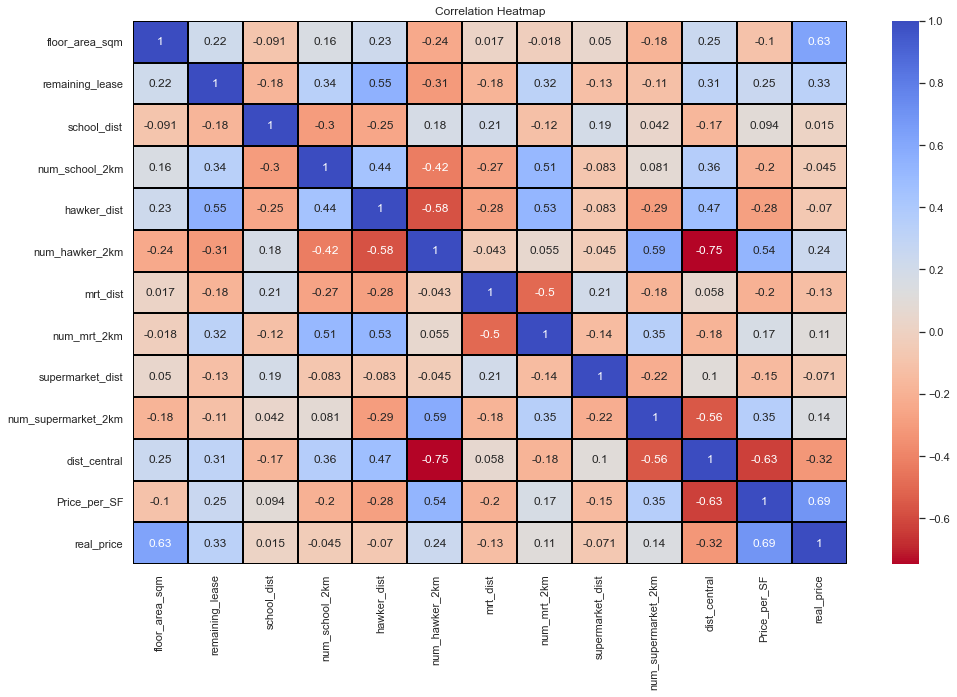

In [6]:
##Plot heatmap to see correlation between each independent feature
fig = plt.figure(figsize=(16,10))
plt.title('Correlation Heatmap')
sns.heatmap(df.corr(), annot = True, cmap = 'coolwarm_r', linecolor = 'black',
            linewidth = 1)

From the heatmap, we can see some features are highly correlated:

1. num_hawker_2km, num_supermarket_2km, dist_central.
Very high negative correlation, especially to hawkers centers. This is probably because central area has very few hawker centers. 

We can drop the num_hawker_2km because we want to study distance to central.

2. Real Price and Floor Area
Both are very correlated. That is to be expected in land scarce Singapore. Perhaps we can use price_per_sf later

### Multicollinearity - VIF
We can use VIF (Variation Inflation Factors) to better identify variables with high multi corllinearity. 

- VIF starts from 1. A value of 1 means that the factor has no correlation to the other factors. 
- VIF value 1 - 5: moderate correlation, no need to remove.

In [8]:
# Multicollinearity
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['meanVIF'] = vif.VIF.mean()

    return(vif.sort_values(by=['VIF'], ascending = False))

calc_vif(df.drop(['real_price', 'Price_per_SF'], axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
1,remaining_lease,39.833406,0.025105,14.079799
10,dist_central,23.007748,0.043464,14.079799
9,num_supermarket_2km,20.323651,0.049204,14.079799
0,floor_area_sqm,17.751123,0.056334,14.079799
3,num_school_2km,14.982207,0.066746,14.079799
4,hawker_dist,10.663740,0.093776,14.079799
7,num_mrt_2km,9.974321,0.100257,14.079799
5,num_hawker_2km,5.140285,0.194542,14.079799
6,mrt_dist,4.746593,0.210677,14.079799
2,school_dist,4.249409,0.235327,14.079799


From the VIF table. We see remaining lease is highest, followed by dist_central, num_supermarket. All are valuable source of information, so we shall not drop them.


We can try to drop 'remaining_lease' on the second run of the Linear Regression Model.

Also, VIF will likely be lower after Feature Scaling.

In [11]:
df.head(2)

,town,flat_type,storey_range,floor_area_sqm,flat_model,remaining_lease,flat,school_dist,num_school_2km,hawker_dist,num_hawker_2km,mrt_dist,num_mrt_2km,supermarket_dist,num_supermarket_2km,dist_central,region,Price_per_SF,real_price
0,QUEENSTOWN,4 ROOM,04 TO 06,88.0,Standard,56,2 HOLLAND AVE,1.203077,6.0,0.214065,5.0,0.242371,8.0,0.300772,15.0,7.109491,Central,6773.368339,596056.413855
1,QUEENSTOWN,4 ROOM,28 TO 30,92.0,Model A,95,23 GHIM MOH LINK,0.849438,4.0,0.329263,6.0,0.459740,7.0,0.054650,15.0,7.736062,Central,7367.106798,677773.825432


## Feature Scaling
Perform feature scaling on continous variables. This is because the independent variables can have highly varying magnitudes, units and range. But since, most of the machine learning algorithms use Eucledian distance between two data points in their computations, this is a problem.

We can check if mean VIF is lower after feature scaling.

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit to continuous columns and transform
scaled_columns = ['floor_area_sqm', 'remaining_lease',
                  'school_dist', 'num_school_2km', 
                  'hawker_dist', 'num_hawker_2km',
                  'mrt_dist', 'num_mrt_2km',
                  'supermarket_dist', 'num_supermarket_2km',
                  'dist_central']
scaler.fit(df[scaled_columns])
scaled_columns = pd.DataFrame(scaler.transform(df[scaled_columns]), index=df.index, columns=scaled_columns)

# separate unscaled features
unscaled_columns = df.drop(scaled_columns, axis=1)

# concatenate scaled and unscaled features
df = pd.concat([scaled_columns,unscaled_columns], axis=1)

In [14]:
df.head(2)

,floor_area_sqm,remaining_lease,school_dist,num_school_2km,hawker_dist,num_hawker_2km,mrt_dist,num_mrt_2km,supermarket_dist,num_supermarket_2km,dist_central,town,flat_type,storey_range,flat_model,flat,region,Price_per_SF,real_price
0,-0.403255,-1.451390,3.263215,-1.103196,-1.105054,0.593504,-0.974087,0.170907,-0.097194,0.035205,-1.179272,QUEENSTOWN,4 ROOM,04 TO 06,Standard,2 HOLLAND AVE,Central,6773.368339,596056.413855
1,-0.237855,1.675905,1.827217,-1.451669,-1.032752,0.851937,-0.413203,0.008344,-1.380184,0.035205,-1.039302,QUEENSTOWN,4 ROOM,28 TO 30,Model A,23 GHIM MOH LINK,Central,7367.106798,677773.825432


### Calculate VIF after scaling

In [15]:
## Calculate VIF after feature scaling
calc_vif(df.drop(['real_price', 'Price_per_SF'], axis=1).select_dtypes(include=['int64','float64']))

,variables,VIF,tolerance,meanVIF
7,num_mrt_2km,4.383056,0.228151,2.431597
4,hawker_dist,4.208738,0.237601,2.431597
5,num_hawker_2km,3.653761,0.273691,2.431597
10,dist_central,3.162297,0.316226,2.431597
3,num_school_2km,2.667708,0.374854,2.431597
9,num_supermarket_2km,2.271114,0.440313,2.431597
1,remaining_lease,1.502714,0.665463,2.431597
6,mrt_dist,1.402262,0.713133,2.431597
2,school_dist,1.212196,0.824949,2.431597
8,supermarket_dist,1.160003,0.862067,2.431597


Mean VIF is much lower now. We have no need to drop any of the features.

### Log Transfrom Target
Real_price and Price_per_SF

<AxesSubplot:xlabel='real_price'>

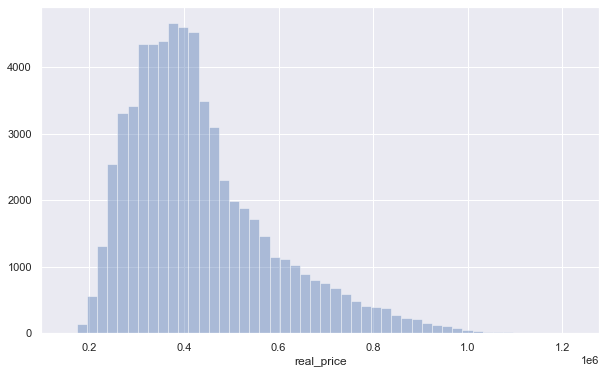

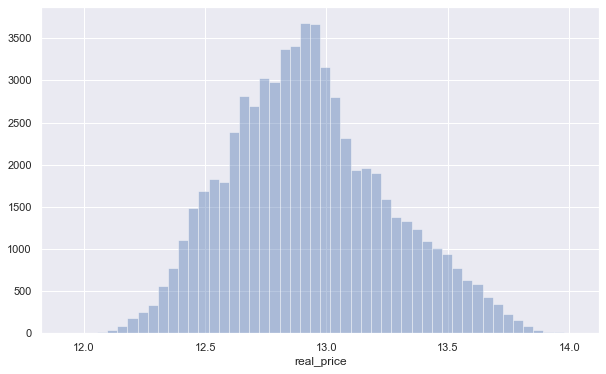

In [50]:
## See distribution of real_price before and after logtransform
plt.figure(figsize = (10, 6))
sns.distplot(df['real_price'], kde = False)
plt.figure(figsize = (10, 6))
sns.distplot(np.log(df['real_price']), kde = False)

In [51]:
df['real_price'] = np.log(df['real_price'])
df['Price_per_SF'] = np.log(df['Price_per_SF'])

### Label Encode
Label encode ordinal variables. Storey_range and Flat-type(number of rooms)


In [22]:
df_backup = df.copy() 

In [52]:
# Label encode flat type
replace_values = {'2 ROOM':0, '3 ROOM':1, '4 ROOM':2, '5 ROOM':3, 'EXECUTIVE':4}
df = df.replace({'flat_type': replace_values})

# label encode storeys
df= df.sort_values(by='storey_range')
df['storey_range'] = df['storey_range'].astype('category').cat.codes

In [53]:
df_backup = df.copy()

## Get Dummies
Get dummies for categorical features: region and flat_model

In [54]:
## Get dummies for region and flat_model
df = pd.get_dummies(df, columns=['region'], prefix=['region']) 
df= df.drop('region_North',axis=1)# Remove North, setting as baseline

df = pd.get_dummies(df, columns=['flat_model'], prefix=['model'])
df= df.drop('model_Standard',axis=1) # remove standard, setting it as the baseline

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64194 entries, 32096 to 3393
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   floor_area_sqm           64194 non-null  float64
 1   remaining_lease          64194 non-null  float64
 2   school_dist              64194 non-null  float64
 3   num_school_2km           64194 non-null  float64
 4   hawker_dist              64194 non-null  float64
 5   num_hawker_2km           64194 non-null  float64
 6   mrt_dist                 64194 non-null  float64
 7   num_mrt_2km              64194 non-null  float64
 8   supermarket_dist         64194 non-null  float64
 9   num_supermarket_2km      64194 non-null  float64
 10  dist_central             64194 non-null  float64
 11  town                     64194 non-null  object 
 12  flat_type                64194 non-null  int64  
 13  storey_range             64194 non-null  int8   
 14  flat               

In [56]:
df.to_csv('Finished Prep Model.csv', index = False)

In [57]:
df.drop(['town', 'flat', 'Price_per_SF'], axis=1, inplace=True)

In [58]:
df.to_csv('Ready for Model.csv', index = False)